# Global Overview Report — Group 6

This notebook provides an interactive overview of abstract embeddings using clustering and dimensionality reduction techniques. It is designed to give a global, interpretable summary of the corpus.

## 1. Load Data from S3
- Connect to the shared S3 bucket and load the daily JSON abstract file.
- Preprocess and filter data as needed.

## 2. Embedding and Dimensionality Reduction
- Generate sentence embeddings using a pretrained model (e.g., all-MiniLM-L6-v2).
- Reduce dimensionality via PCA for visualization.

## 3. Clustering and Topic Analysis
- Apply KMeans clustering to group semantically similar abstracts.
- Visualize clusters in PCA space.
- Identify top keywords per cluster for interpretability.

## 4. Interactive Exploration
- Annotate abstracts with cluster labels.
- Optionally display representative titles from each cluster.
- Plot keyword frequency and word clouds per cluster (if desired).

---

This report provides high-level trends in the abstract dataset and supports further tuning (e.g., topic modeling)._  
Later integration with MongoDB and automation via Papermill is expected as part of the pipeline.


## Setup

This cell ensures your runtime has the exact tooling the notebook needs for the pipeline: boto3/smart_open for S3 I/O (incl. streaming and .gz), sentence-transformers for text embeddings, scikit-learn for PCA/KMeans/TF-IDF, and matplotlib/seaborn/plotly for viz. wordcloud supports quick topic visuals; ipywidgets enables lightweight UI. The -q keeps installs quiet to reduce noise.

It then checks the environment: on Colab, widgets work out of the box; on classic Jupyter, it enables the widgets extension so sliders/buttons render. This is idempotent and safe. If widgets don’t appear, refresh or restart the kernel once.

In [1]:
# Env check only (no installs here).
import importlib
pkgs = ["boto3","smart_open","wordcloud","sklearn","sentence_transformers","matplotlib","seaborn","ipywidgets","plotly"]
missing = [p for p in pkgs if importlib.util.find_spec(p.replace("-","_")) is None]
print("Missing:", missing or "none")
# If any are missing: install in Terminal (not here): pip install <pkg>


Missing: none


## Load Data from MongoDB

In [2]:
import os, pandas as pd
from pymongo import MongoClient
from dotenv import load_dotenv

load_dotenv()
MONGO_URI = os.getenv("MONGO_URI", "mongodb://localhost:27018/")
DB_NAME, COLL_NAME = "semantic_nlp", "biorxiv_articles"

client = MongoClient(MONGO_URI, uuidRepresentation="standard")
coll = client[DB_NAME][COLL_NAME]
projection = {"_id":0,"doi":1,"title":1,"authors":1,"category":1,
              "date":1,"server":1,"abstract":1,"source":1,"reference_summary":1}
df = pd.DataFrame(list(coll.find({}, projection)))

if "doi" in df.columns: df = df.drop_duplicates(subset=["doi"], keep="first")
text_col = "abstract" if ("abstract" in df and df["abstract"].notna().any()) else "source"
df = df.rename(columns={text_col:"abstract"}).dropna(subset=["abstract"]).copy()
if "date" in df.columns: df["date"] = pd.to_datetime(df["date"], errors="coerce")

print(df.shape)
df.head(3)


(99, 9)


,doi,title,authors,category,abstract,date,server,source,reference_summary
0,10.1101/461517,Distinguishing multiple-merger from Kingman co...,"Fenton, E. F.; Rice, D. P.; Novembre, J.; Desa...",evolutionary biology,Demographic inference methods in population ge...,2024-08-07,biorxiv,Distinguishing multiple-merger from Kingman co...,
1,10.1101/803205,Caliban: Accurate cell tracking and lineage co...,"Schwartz, M.; Moen, E.; Miller, G.; Dougherty,...",bioinformatics,While live-cell imaging is a powerful approach...,2024-08-07,biorxiv,Caliban: Accurate cell tracking and lineage co...,
2,10.1101/2020.04.04.024703,Neural circuit mechanisms for steering control...,"Rayshubskiy, A.; Holtz, S. L.; Bates, A.; Vand...",neuroscience,Orienting behaviors provide a continuous strea...,2024-08-07,biorxiv,Neural circuit mechanisms for steering control...,


In [3]:
# --- (a) optional: remove duplicate DOIs inside Mongo, keep the first copy
dups = list(coll.aggregate([
    {"$match": {"doi": {"$exists": True, "$ne": None}}},
    {"$group": {"_id": "$doi", "ids": {"$push": "$_id"}, "count": {"$sum": 1}}},
    {"$match": {"count": {"$gt": 1}}}
]))
removed = 0
for d in dups:
    # keep the first, remove the rest
    for _id in d["ids"][1:]:
        coll.delete_one({"_id": _id})
        removed += 1
print(f"Removed {removed} duplicate docs in Mongo.")


Removed 0 duplicate docs in Mongo.


In [4]:
# --- (b) create indexes
# text index for faster search
coll.create_index([("abstract", "text"), ("title", "text")], name="abstract_title_text")

# unique DOI so future imports can't duplicate (will work now that dupes are gone)
try:
    coll.create_index("doi", unique=True, name="uniq_doi")
    print("Unique DOI index created.")
except Exception as e:
    print("Unique index skipped:", e)

# sanity check: list indexes
coll.index_information()


Unique DOI index created.


{'_id_': {'v': 2, 'key': [('_id', 1)]},
 'abstract_title_text': {'v': 2,
  'key': [('_fts', 'text'), ('_ftsx', 1)],
  'weights': SON([('abstract', 1), ('title', 1)]),
  'default_language': 'english',
  'language_override': 'language',
  'textIndexVersion': 3},
 'uniq_doi': {'v': 2, 'key': [('doi', 1)], 'unique': True}}

In [5]:
# --- (c) quick search test (should return a few titles or an empty list without error)
list(coll.find({"$text": {"$search": "CRISPR OR gene"}}, {"_id": 0, "title": 1}).limit(5))

[{'title': 'Single component CRISPR-mediated base-editors for Agrobacterium and their use to develop an improved suite of strains'},
 {'title': 'GBP2 engages Galectin-9 for immunity against Toxoplasma gondii'},
 {'title': 'An enhanced Eco1 retron editor enables precision genome engineering in human cells from a single-copy integrated lentivirus'},
 {'title': 'A WFS1 variant disrupting acceptor splice site uncovers the impact of alternative splicing on β cell apoptosis in a patient with Wolfram syndrome.'},
 {'title': 'p110alpha-dependent hepatocyte signaling is critical for liver gene expression and its rewiring in MASLD'}]

In [20]:
# Config & env
import os
from dotenv import load_dotenv, find_dotenv
load_dotenv(find_dotenv(), override=True)

BASE   = os.getenv("BASE_MODEL_ID", "unsloth/Llama-3.2-1B-Instruct")
# Point to your local adapters folder (from Owen’s run):
ADAPTER_LOCAL_DIR = os.getenv(
    "ADAPTER_LOCAL_DIR",
    "models/unsloth_Llama-3.2-1B_20250811_212126/lora_weights",  # <-- update default
)

# Optional S3 (only used if set + creds available via profile/role/env)
AWS_REGION = os.getenv("AWS_REGION", "us-east-1")
S3_BUCKET  = os.getenv("S3_BUCKET")        # e.g. watspeed-data-gr-project
S3_KEY     = os.getenv("S3_ADAPTER_KEY")   # e.g. models/llama1b/...tar.gz
AWS_PROFILE= os.getenv("AWS_PROFILE")      # optional for local dev


## Model & Adapters — local-first (optional S3)
Loads Llama-3.2-1B and tries to attach Unsloth LoRA adapters.
- Prefers `ADAPTER_LOCAL_DIR`
- If not found and `S3_BUCKET`/`S3_ADAPTER_KEY` are set with creds, downloads once into `models/`
- Otherwise proceeds with base model only


In [21]:
# Load Llama-3.2-1B + Unsloth LoRA: prefer local; try S3 via env; else base only
import os, io, tarfile, glob, boto3
from botocore.exceptions import ClientError, NoCredentialsError, BotoCoreError
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer
from peft import PeftModel

def find_local_adapters(root="models"):
    for p in glob.glob(os.path.join(root, "**"), recursive=True):
        if os.path.isdir(p) and os.path.exists(os.path.join(p, "adapter_config.json")):
            return p
    return None

def try_s3_download(bucket, key, region, profile):
    if not (bucket and key): return None
    try:
        sess = boto3.Session(profile_name=profile, region_name=region)
        s3   = sess.client("s3")
        print(f"Downloading s3://{bucket}/{key} …")
        body = s3.get_object(Bucket=bucket, Key=key)["Body"].read()
        os.makedirs("models", exist_ok=True)
        with tarfile.open(fileobj=io.BytesIO(body), mode="r:gz") as tar:
            tar.extractall("models")
        return find_local_adapters("models")
    except (NoCredentialsError, ClientError, BotoCoreError) as e:
        print("S3 unavailable:", e); return None

# 1) prefer explicit local → 2) scan models/ → 3) try S3 → 4) none
adapter_dir = (
    ADAPTER_LOCAL_DIR if os.path.isdir(ADAPTER_LOCAL_DIR)
    else (find_local_adapters("models") or try_s3_download(S3_BUCKET, S3_KEY, AWS_REGION, AWS_PROFILE))
)

base = AutoModelForCausalLM.from_pretrained(BASE, torch_dtype=torch.float32)
tok  = AutoTokenizer.from_pretrained(BASE, use_fast=True); tok.pad_token = tok.eos_token

model = base
if adapter_dir:
    try:
        model = PeftModel.from_pretrained(base, adapter_dir).merge_and_unload()
        print("✅ Loaded base + LoRA from:", adapter_dir)
    except Exception as e:
        print("⚠️ Adapters load failed; using base only.", e)
else:
    print("⚠️ No adapters found; using base only.")
model.eval()


S3 unavailable: An error occurred (InvalidToken) when calling the GetObject operation: The provided token is malformed or otherwise invalid.
⚠️ No adapters found; using base only.


LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(128256, 2048, padding_idx=128004)
    (layers): ModuleList(
      (0-15): 16 x LlamaDecoderLayer(
        (self_attn): LlamaAttention(
          (q_proj): Linear(in_features=2048, out_features=2048, bias=False)
          (k_proj): Linear(in_features=2048, out_features=512, bias=False)
          (v_proj): Linear(in_features=2048, out_features=512, bias=False)
          (o_proj): Linear(in_features=2048, out_features=2048, bias=False)
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear(in_features=2048, out_features=8192, bias=False)
          (up_proj): Linear(in_features=2048, out_features=8192, bias=False)
          (down_proj): Linear(in_features=8192, out_features=2048, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): LlamaRMSNorm((2048,), eps=1e-05)
        (post_attention_layernorm): LlamaRMSNorm((2048,), eps=1e-05)
      )
    )
    (norm): LlamaRMSNorm((2048,), eps=1e-0

In [22]:
import torch

def summarize(text: str, max_new_tokens: int = 150) -> str:
    prompt = (
        "### Instruction:\nSummarize the abstract.\n\n"
        f"### Input:\n{text}\n\n"
        "### Response:\n"
    )
    inputs = tok(prompt, return_tensors="pt")
    with torch.no_grad():
        out = model.generate(**inputs, max_new_tokens=max_new_tokens)
    return tok.decode(out[0], skip_special_tokens=True)

# Smoke test if df exists
try:
    print("Example:", summarize(df['abstract'].iloc[0])[:200], "…")
except Exception as e:
    print("Ready. Call summarize(<abstract_text>).", e)


Example: ### Instruction:
Summarize the abstract.

### Input:
Demographic inference methods in population genetics typically assume that the ancestry of a sample can be modeled by the Kingman coalescent. A def …


 ## Basic Cleaning & Summary

<class 'pandas.core.frame.DataFrame'>
Index: 99 entries, 0 to 99
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   doi                99 non-null     object        
 1   title              99 non-null     object        
 2   authors            99 non-null     object        
 3   category           99 non-null     object        
 4   abstract           99 non-null     object        
 5   date               99 non-null     datetime64[ns]
 6   server             99 non-null     object        
 7   source             99 non-null     object        
 8   reference_summary  99 non-null     object        
 9   word_count         99 non-null     int64         
dtypes: datetime64[ns](1), int64(1), object(8)
memory usage: 8.5+ KB
None


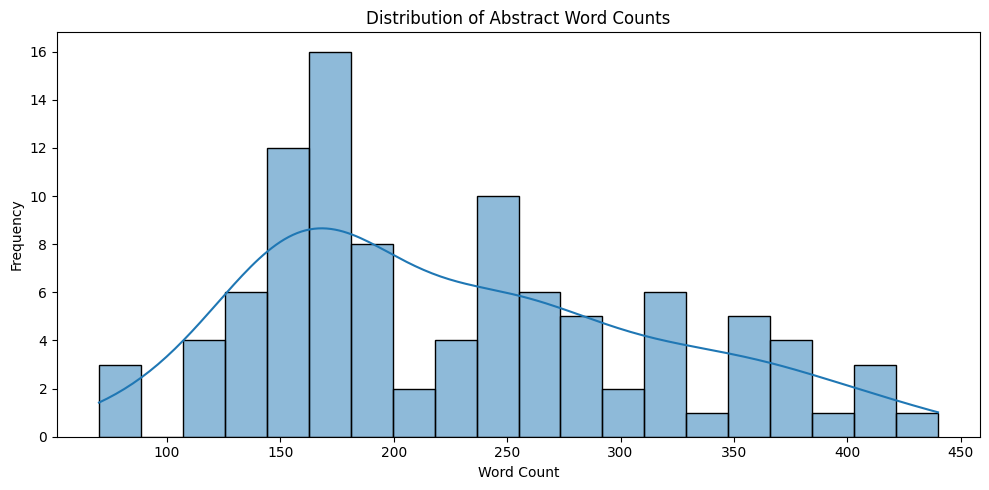

count     99.000000
mean     228.515152
std       87.334960
min       70.000000
25%      162.500000
50%      203.000000
75%      284.000000
max      440.000000
Name: word_count, dtype: float64

In [8]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Ensure 'date' column is parsed if present
if "date" in df.columns:
    df["date"] = pd.to_datetime(df["date"], errors="coerce")

# Require non-null abstracts
if "abstract" not in df.columns:
    raise ValueError("Expected an 'abstract' column in the data.")
df = df.dropna(subset=["abstract"]).copy()

# Early exit if nothing to plot
if df.empty:
    print("No rows with non-null abstracts; nothing to plot.")
else:
    # Word count
    df["word_count"] = df["abstract"].astype(str).str.split().str.len()

    print(df.info())

    # Histogram of abstract lengths
    plt.figure(figsize=(10, 5))
    sns.histplot(df["word_count"], kde=True, bins=20)
    plt.title("Distribution of Abstract Word Counts")
    plt.xlabel("Word Count")
    plt.ylabel("Frequency")
    plt.tight_layout()
    plt.show()

    display(df["word_count"].describe())


## Embedding and Dimensionality Reduction

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

C:\Users\darak\PycharmProjects\watspeed_big_data_tools_group_project\.venv\lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\darak\.cache\huggingface\hub\models--sentence-transformers--all-MiniLM-L6-v2. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Embedding shape: (99, 384)
Saved: abstract_embeddings.csv and abstract_embeddings_2d.csv


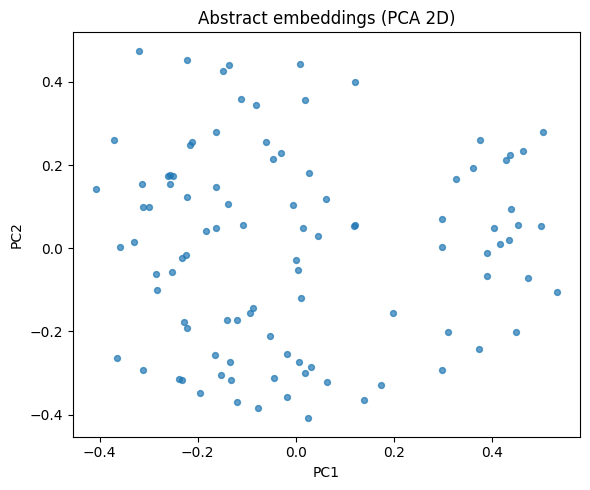

In [9]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sentence_transformers import SentenceTransformer
from sklearn.decomposition import PCA

# guard: ensure we have text
df_text = df.dropna(subset=["abstract"]).copy()
if df_text.empty:
    raise ValueError("No abstracts to embed.")

texts = df_text["abstract"].astype(str).tolist()

# load model (downloads once, then cached)
model = SentenceTransformer("all-MiniLM-L6-v2", device="cpu")

# embeddings (L2-normalized) -> numpy float32
embeddings = model.encode(
    texts,
    show_progress_bar=True,
    convert_to_numpy=True,
    normalize_embeddings=True,
    batch_size=32,
)
embeddings = embeddings.astype(np.float32)

# wrap in DF and keep an ID (e.g., DOI) to join back later
embedding_df = pd.DataFrame(embeddings)
embedding_df.index = df_text.index  # align with original rows

# PCA to 2D for quick viz
pca = PCA(n_components=2, random_state=42)
embedding_2d = pca.fit_transform(embeddings)
embed2d_df = pd.DataFrame(embedding_2d, columns=["pc1", "pc2"], index=df_text.index)

print("Embedding shape:", embedding_df.shape)

# Save artifacts
embedding_df.to_csv("abstract_embeddings.csv", index_label="row_id")
embed2d_df.to_csv("abstract_embeddings_2d.csv", index_label="row_id")
print("Saved: abstract_embeddings.csv and abstract_embeddings_2d.csv")

# quick scatter
plt.figure(figsize=(6, 5))
plt.scatter(embed2d_df["pc1"], embed2d_df["pc2"], s=18, alpha=0.7)
plt.title("Abstract embeddings (PCA 2D)")
plt.xlabel("PC1"); plt.ylabel("PC2")
plt.tight_layout()
plt.show()


## PCA Scatter (annotate first 20)

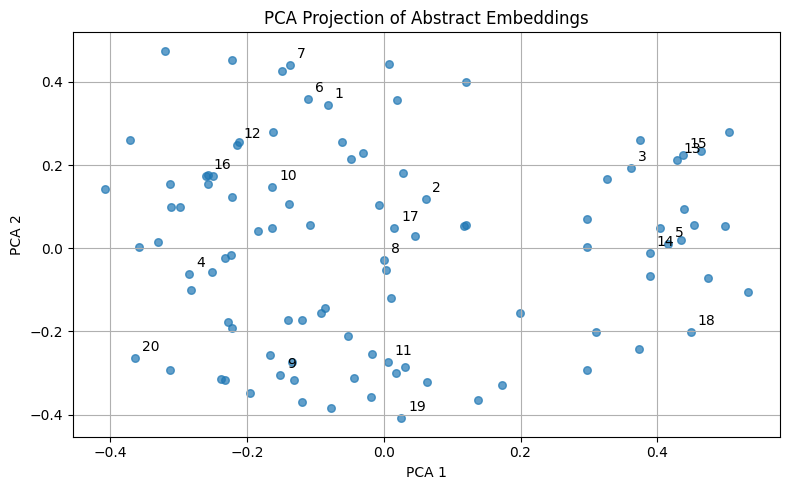

1. Distinguishing multiple-merger from Kingman coalescence using two-site frequency spectra
2. Caliban: Accurate cell tracking and lineage construction in live-cell imaging experiments with deep learning
3. Neural circuit mechanisms for steering control in walking Drosophila
4. GBP2 engages Galectin-9 for immunity against Toxoplasma gondii
5. Synaptic Potentiation of Engram cells is Necessary and Sufficient for Context Fear Memory
6. modelRxiv: A platform for the dissemination and interactive display of models
7. A computational model of fractal interface formation in bacterial biofilms
8. Predicting murine age across tissues and cell types using single cell transcriptome data
9. Helminth-derived metabolites induce tolerogenic functional, metabolic, and transcriptional signatures in dendritic cells that attenuate experimental colitis
10. SICKO: Systematic Imaging of Caenorhabtidis Killing Organisms
11. RBM3 enhances cold resistance by regulating thermogenic gene expressions
12. Migrati

In [11]:
# assume you built embeddings from df_text = df.dropna(subset=["abstract"])
# and embedding_2d = PCA(...).fit_transform(embeddings)

# Build a plotting frame aligned to the embedded rows
plot_df = pd.DataFrame(embedding_2d, columns=["pc1","pc2"], index=df_text.index)
plot_df = plot_df.join(df_text[["title"]], how="left")

plt.figure(figsize=(8, 5))
plt.scatter(plot_df["pc1"], plot_df["pc2"], s=30, alpha=0.7)

# Annotate up to 20 points
n = min(20, len(plot_df))
for i, (x, y) in enumerate(plot_df[["pc1","pc2"]].head(n).to_numpy()):
    plt.annotate(str(i+1), (x, y), xytext=(5, 5), textcoords="offset points")

plt.title("PCA Projection of Abstract Embeddings")
plt.xlabel("PCA 1"); plt.ylabel("PCA 2"); plt.grid(True); plt.tight_layout()
plt.show()

# Number → title mapping (so you know what each label is)
labels = [f"{i+1}. {t}" for i, t in enumerate(plot_df["title"].head(n).fillna("Untitled"))]
print("\n".join(labels))


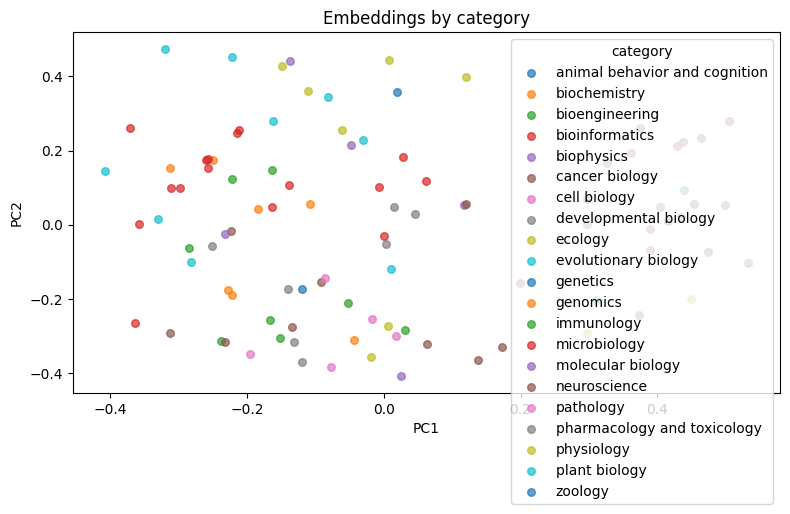

In [12]:
if "category" in df_text.columns:
    plt.figure(figsize=(8,5))
    for cat, g in plot_df.join(df_text["category"]).groupby("category"):
        plt.scatter(g["pc1"], g["pc2"], s=30, alpha=0.7, label=str(cat))
    plt.legend(title="category"); plt.title("Embeddings by category")
    plt.xlabel("PC1"); plt.ylabel("PC2"); plt.tight_layout(); plt.show()


## Clustering and Topic Analysis

Silhouette: 0.04387252405285835


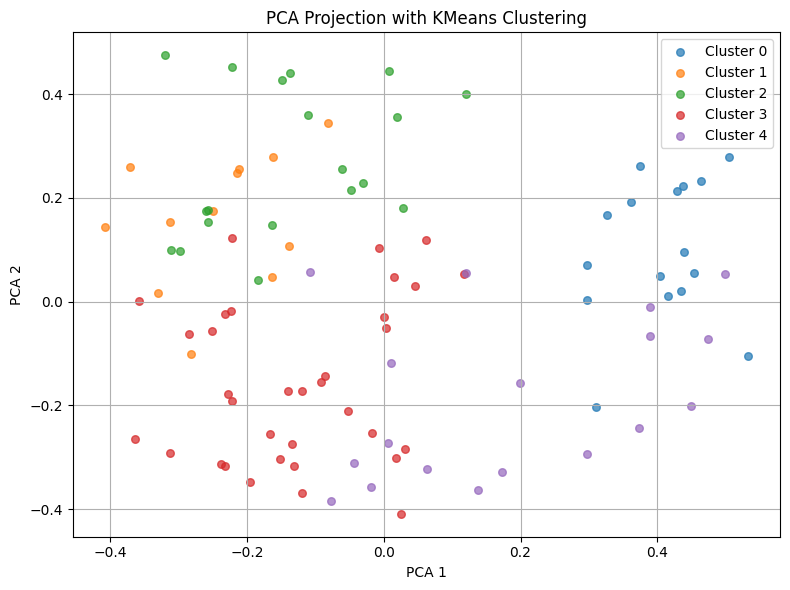


Cluster 0 — 16 abstracts:
 • Neural circuit mechanisms for steering control in walking Drosophila
 • Synaptic Potentiation of Engram cells is Necessary and Sufficient for Context Fear Memory
 • Dynamic organization of visual cortical networks inferred from massive spiking datasets.
 • Neural signatures of attentional prioritization and facilitation in accessing repeated items inVisual Working memory
 • Cortical areas for planning sequences before and during movement
 • Enhanced EEG Forecasting: A Probabilistic Deep Learning Approach
 • A circadian behavioral analysis suite for real-time classification of daily rhythms in complex behaviors
 • A Curated Compendium of Transcriptomic Data for the Exploration of Neocortical Development
 • Enhanced Working Memory Representations for Rare Events
 • Imaging the large-scale and cellular response to focal traumatic brain injury in mouse neocortex
   … (+6 more)

Cluster 1 — 12 abstracts:
 • Distinguishing multiple-merger from Kingman coalescenc

In [13]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Use the same filtered rows you embedded
df_text = df.dropna(subset=["abstract"]).copy()

# Feature matrix for KMeans (use your existing embeddings/embedding_df)
# If you have `embeddings` as a numpy array, use that. Otherwise:
X = embedding_df.loc[df_text.index].to_numpy()

N_CLUSTERS = 5
kmeans = KMeans(n_clusters=N_CLUSTERS, random_state=42, n_init=10)
labels = kmeans.fit_predict(X)

# Attach labels to the filtered frame and back-fill into the full df
df_text["cluster"] = labels
df["cluster"] = pd.NA
df.loc[df_text.index, "cluster"] = labels

# Quick quality check
print("Silhouette:", silhouette_score(X, labels))

# Plot on your 2D projection (which was built for the same rows)
plot_df = pd.DataFrame(embedding_2d, columns=["pc1","pc2"], index=df_text.index)
plot_df["cluster"] = labels

plt.figure(figsize=(8, 6))
for cid, g in plot_df.groupby("cluster"):
    plt.scatter(g["pc1"], g["pc2"], alpha=0.7, s=30, label=f"Cluster {cid}")
plt.title("PCA Projection with KMeans Clustering")
plt.xlabel("PCA 1"); plt.ylabel("PCA 2"); plt.legend()
plt.grid(True); plt.tight_layout(); plt.show()

# Titles per cluster (top 10)
if "title" in df_text.columns:
    for cid, g in df_text.groupby("cluster"):
        titles = g["title"].fillna("Untitled").tolist()
        print(f"\nCluster {cid} — {len(titles)} abstracts:")
        for t in titles[:10]:
            print(" •", t)
        if len(titles) > 10:
            print(f"   … (+{len(titles)-10} more)")


## Top TF‑IDF Keywords per Cluster

In [14]:
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer

df_text = df.dropna(subset=["abstract", "cluster"]).copy()

for cluster_id, group in df_text.groupby("cluster"):
    abstracts = group["abstract"].astype(str).tolist()
    if len(abstracts) == 0:
        continue

    vectorizer = TfidfVectorizer(
        stop_words="english",
        ngram_range=(1, 2),   # unigrams + bigrams
        min_df=2,             # ignore ultra-rare terms
        max_df=0.9,           # ignore overly common terms
        sublinear_tf=True,    # log-scale term frequency
    )
    X = vectorizer.fit_transform(abstracts)          # shape: (docs, terms)
    terms = np.array(vectorizer.get_feature_names_out())

    # mean TF-IDF weight per term across the cluster
    mean_w = X.mean(axis=0).A1                       # shape: (terms,)
    top_idx = mean_w.argsort()[::-1][:10]            # top 10 by weight

    print(f"\nCluster {cluster_id} — Top Keywords:")
    print(", ".join(terms[top_idx]))



Cluster 0 — Top Keywords:
brain, neurons, memory, model, neural, eeg, high, imaging, visual, cortical

Cluster 1 — Top Keywords:
expression, population, plant, gene, diversity, genes, genetic, seq, strains, data

Cluster 2 — Top Keywords:
growth, species, results, structural, model, complex, different, cell, models, cellular

Cluster 3 — Top Keywords:
cells, cell, expression, gene, analysis, using, study, cellular, cancer, induced

Cluster 4 — Top Keywords:
neurons, mice, cells, induced, cell, expression, signaling, receptors, exposure, responses


## Word Clouds per Cluster

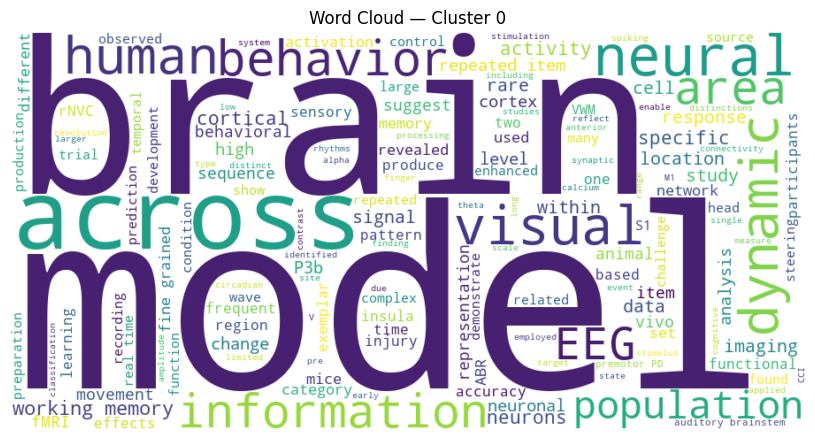

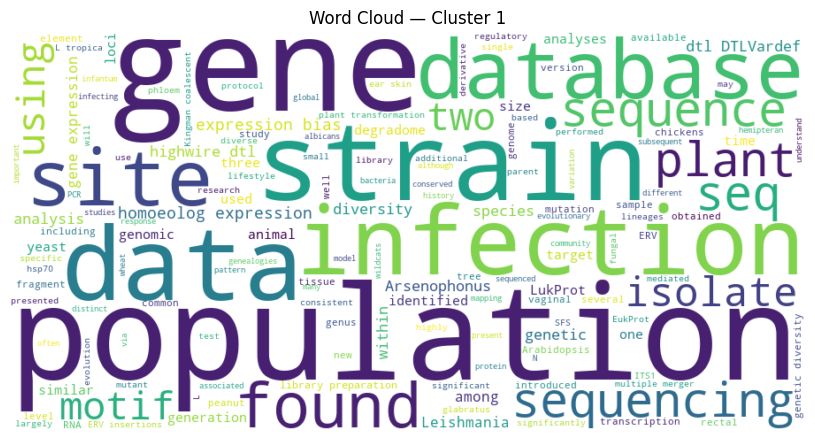

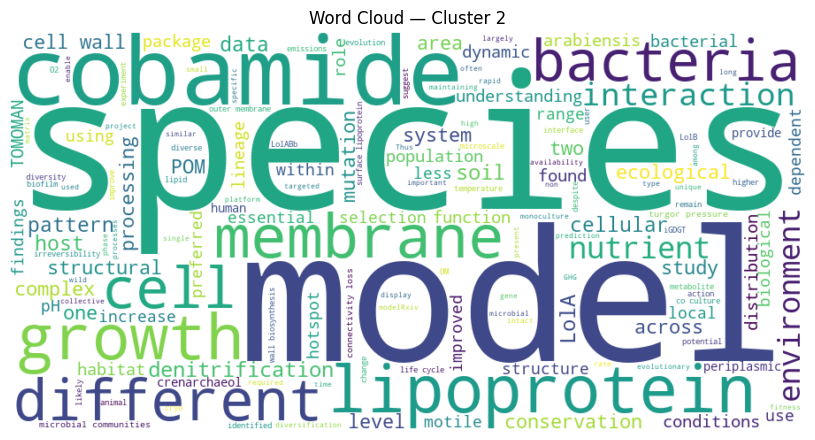

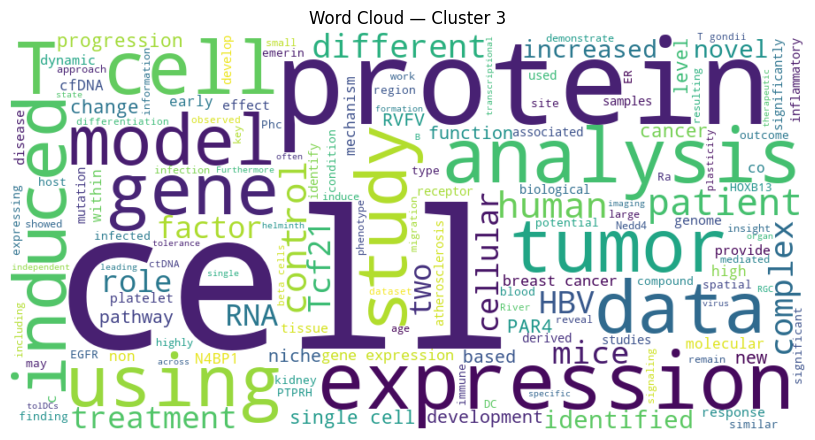

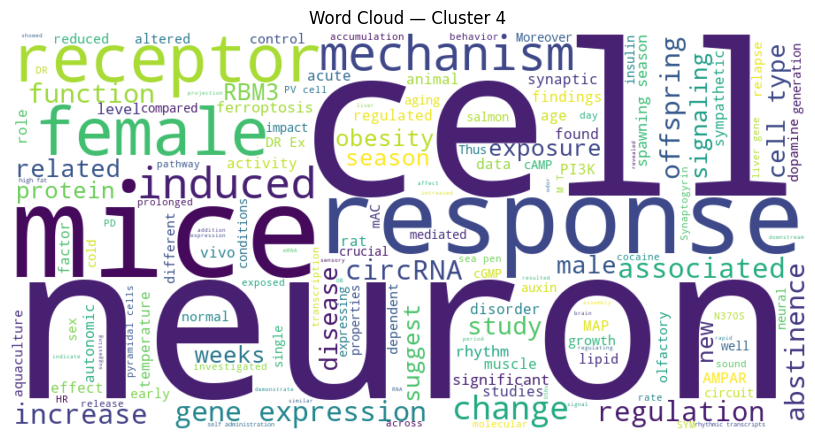

In [15]:
from wordcloud import WordCloud, STOPWORDS

# add a few domain stopwords so they don't swamp the clouds
extra_stop = {"et", "al", "biorxiv", "preprint", "copyright",
              "abstract", "introduction", "methods", "results", "conclusion"}
stops = STOPWORDS | extra_stop

for cid, g in df.dropna(subset=["cluster", "abstract"]).groupby("cluster"):
    text = " ".join(g["abstract"].astype(str))
    wc = WordCloud(
        width=900, height=450,
        background_color="white",
        stopwords=stops,
        collocations=True,       # allow phrases
        max_words=150,
        random_state=42          # reproducible layout
    ).generate(text)

    plt.figure(figsize=(9, 4.5))
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title(f"Word Cloud — Cluster {cid}")
    plt.tight_layout()
    plt.show()


## In‑cluster Semantic Search (interactive)

In [16]:
# Pre-reqs: you already ran SentenceTransformer(...) as `model`,
# and you created `embedding_df` (same rows as the texts you embedded).
# Make sure the embedding_df index aligns to the original df (we set this earlier):
# embedding_df.index = df_text.index

import numpy as np
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
import ipywidgets as widgets
from IPython.display import display

# We'll search only over rows we actually embedded:
search_index = embedding_df.index              # indices into df
X = embedding_df.to_numpy()                    # (M, D) normalized embeddings

# UI
q_box        = widgets.Text(value='protein structure embeddings', description='Query', layout=widgets.Layout(width='60%'))
cluster_box  = widgets.Text(value='', description='Cluster (opt)')
topk_slider  = widgets.IntSlider(value=5, min=1, max=20, step=1, description='TopK')
btn_search   = widgets.Button(description='Search')
out_search   = widgets.Output()

def run_search(_):
    with out_search:
        out_search.clear_output(wait=True)
        q = q_box.value.strip()
        if not q:
            print("Enter a query string.")
            return

        # encode query (normalized)
        qv = model.encode([q], convert_to_numpy=True, normalize_embeddings=True)
        # since vectors are normalized, dot = cosine; cosine_similarity also fine
        S = (qv @ X.T).ravel()  # shape (M,)

        # optional cluster filter
        mask = np.ones(len(search_index), dtype=bool)
        if cluster_box.value.strip():
            try:
                cval = int(cluster_box.value.strip())
                if 'cluster' in df.columns:
                    # build mask over the *embedded* rows only
                    mask = (df.loc[search_index, 'cluster'] == cval).to_numpy()
                else:
                    print("No 'cluster' column found. Run clustering first.")
            except ValueError:
                print("Cluster filter ignored (not an int).")

        # apply mask by setting disallowed scores to -inf
        S_masked = np.where(mask, S, -np.inf)

        # top-k
        k = min(topk_slider.value, np.isfinite(S_masked).sum())
        if k == 0:
            print("No results (try a different query or cluster).")
            return

        top_idx = np.argpartition(S_masked, -k)[-k:]
        top_idx = top_idx[np.argsort(S_masked[top_idx])[::-1]]  # sort high→low

        # pretty print
        for rank, j in enumerate(top_idx, start=1):
            row_id = search_index[j]              # original df index
            score  = S_masked[j]
            title  = df.at[row_id, 'title'] if 'title' in df.columns else f"Abstract {row_id}"
            date_s = ""
            if "date" in df.columns and pd.notnull(df.at[row_id, "date"]):
                date_s = str(pd.to_datetime(df.at[row_id, "date"]).date())
            cl_s = f"  (cluster {df.at[row_id, 'cluster']})" if 'cluster' in df.columns and pd.notnull(df.at[row_id, 'cluster']) else ""
            print(f"[{rank:>2}] {score:.3f} — {title} — {date_s}{cl_s}")

btn_search.on_click(run_search)
display(widgets.HBox([q_box, cluster_box, topk_slider]), btn_search, out_search)


Button(description='Search', style=ButtonStyle())

Output()

# Appendix — Minimal **Unsloth** Fine‑Tuning (Llama‑3.2‑1B)

This appendix adds a **small** Unsloth training workflow with **minimal changes** to your report notebook.

Steps:
- Install (Colab‑friendly)
- Load **Llama‑3.2‑1B** with Unsloth + LoRA
- Prep **Alpaca** dataset
- Train via **TRL SFTTrainer**
- Quick inference
- Save LoRA adapters


In [1]:
# %%capture
# Minimal Colab install (mirrors Unsloth's template). If you aren't in Colab, just `pip install unsloth`.
import os
if "COLAB_" not in "".join(os.environ.keys()):
    !pip install -q unsloth
else:
    !pip install -q --no-deps bitsandbytes accelerate xformers==0.0.29.post3 peft trl==0.15.2 triton cut_cross_entropy unsloth_zoo
    !pip install -q sentencepiece protobuf "datasets>=3.4.1" huggingface_hub hf_transfer
    !pip install -q --no-deps unsloth

print("✅ Unsloth install complete. If you see CUDA/bitsandbytes errors, Runtime → Restart and re-run.")

NotImplementedError: Unsloth currently only works on NVIDIA GPUs and Intel GPUs.

In [10]:
import unsloth, torch
print("Unsloth ready. CUDA:", torch.cuda.is_available())


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.4/43.4 MB 36.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 318.9/318.9 kB 35.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.9/72.9 MB 25.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.4/176.4 kB 21.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.4/47.4 kB 553.2 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 306.8/306.8 kB 2.3 MB/s eta 0:00:00
✅ Unsloth install complete. If you see CUDA/bitsandbytes errors, Runtime → Restart and re-run.


In [11]:
# Unsloth model load (minimal)
from unsloth import FastLanguageModel
import torch

max_seq_length = 2048     # RoPE scaling handled internally
dtype = None              # auto (fp16 on T4/V100; bf16 on Ampere+)
load_in_4bit = False      # set True to save VRAM

# Optional pre-quantized 4-bit models (faster downloads / fewer OOMs):
# fourbit_models = [
#   "unsloth/Meta-Llama-3.1-8B-Instruct-bnb-4bit",
#   "unsloth/mistral-7b-instruct-v0.3-bnb-4bit",
#   "unsloth/Phi-3.5-mini-instruct",
# ]

model, tokenizer = FastLanguageModel.from_pretrained(
    model_name = "unsloth/Llama-3.2-1B",
    max_seq_length = max_seq_length,
    dtype = dtype,
    load_in_4bit = load_in_4bit,
    # token = "hf_...",  # if using gated models
)

# Add LoRA adapters (same targets as template)
model = FastLanguageModel.get_peft_model(
    model,
    r = 16,
    target_modules = ["q_proj", "k_proj", "v_proj", "o_proj",
                      "gate_proj", "up_proj", "down_proj"],
    lora_alpha = 16,
    lora_dropout = 0.0,
    bias = "none",
    use_gradient_checkpointing = "unsloth",
    random_state = 3407,
    use_rslora = False,
    loftq_config = None,
)

print("✅ Unsloth model ready.")

/tmp/ipython-input-459911168.py:2: UserWarning: WARNING: Unsloth should be imported before transformers, peft to ensure all optimizations are applied. Your code may run slower or encounter memory issues without these optimizations.

Please restructure your imports with 'import unsloth' at the top of your file.
  from unsloth import FastLanguageModel


🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
🦥 Unsloth Zoo will now patch everything to make training faster!
==((====))==  Unsloth 2025.8.4: Fast Llama patching. Transformers: 4.55.0.
   \\   /|    Tesla T4. Num GPUs = 1. Max memory: 14.741 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.6.0+cu124. CUDA: 7.5. CUDA Toolkit: 12.4. Triton: 3.2.0
\        /    Bfloat16 = FALSE. FA [Xformers = 0.0.29.post3. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


model.safetensors:   0%|          | 0.00/2.47G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/230 [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/459 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.2M [00:00<?, ?B/s]

Unsloth 2025.8.4 patched 16 layers with 16 QKV layers, 16 O layers and 16 MLP layers.


✅ Unsloth model ready.


In [13]:
# Data Prep — Alpaca (same prompt format as template)
from datasets import load_dataset

alpaca_prompt = r"""Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request.

### Instruction:
{}

### Input:
{}

### Response:
{}"""

EOS_TOKEN = None

def formatting_prompts_func(examples):
    global EOS_TOKEN
    if EOS_TOKEN is None:
        # assumes `tokenizer` exists in your notebook
        EOS_TOKEN = getattr(tokenizer, "eos_token", "")
    instructions = examples["instruction"]
    inputs       = examples["input"]
    outputs      = examples["output"]
    texts = []
    for instruction, inp, output in zip(instructions, inputs, outputs):
        text = alpaca_prompt.format(instruction, inp or "", output) + EOS_TOKEN
        texts.append(text)
    return {"text": texts}

dataset = load_dataset("yahma/alpaca-cleaned", split="train")
dataset = dataset.map(formatting_prompts_func, batched=True, remove_columns=dataset.column_names)

print("✅ Dataset ready:", dataset)


Map:   0%|          | 0/51760 [00:00<?, ? examples/s]

✅ Dataset ready: Dataset({
    features: ['text'],
    num_rows: 51760
})


In [14]:
# Train (TRL SFTTrainer)
from trl import SFTTrainer
from transformers import TrainingArguments
from unsloth import is_bfloat16_supported

trainer = SFTTrainer(
    model = model,
    tokenizer = tokenizer,
    train_dataset = dataset,
    dataset_text_field = "text",
    max_seq_length = max_seq_length,
    dataset_num_proc = 2,
    packing = False,
    args = TrainingArguments(
        per_device_train_batch_size = 2,
        gradient_accumulation_steps = 4,
        warmup_steps = 5,
        # num_train_epochs = 1,   # alternative to max_steps
        max_steps = 60,          # quick demo; increase for real finetune
        learning_rate = 2e-4,
        fp16 = not is_bfloat16_supported(),
        bf16 = is_bfloat16_supported(),
        logging_steps = 1,
        optim = "adamw_8bit",
        weight_decay = 0.01,
        lr_scheduler_type = "linear",
        seed = 3407,
        output_dir = "outputs_unsloth",
        report_to = "none",
    ),
)

# Optional memory stats (as in template)
if torch.cuda.is_available():
    gpu_props = torch.cuda.get_device_properties(0)
    start_mem = round(torch.cuda.max_memory_reserved() / 1024**3, 3)
    max_mem   = round(gpu_props.total_memory / 1024**3, 3)
    print(f"GPU = {gpu_props.name}. Max memory = {max_mem} GB.")
    print(f"{start_mem} GB of memory reserved.")

trainer_stats = trainer.train()

if torch.cuda.is_available():
    end_mem = round(torch.cuda.max_memory_reserved() / 1024**3, 3)
    delta_mem = round(end_mem - start_mem, 3)
    print(f"{trainer_stats.metrics['train_runtime']} seconds used for training.")
    print(f"{round(trainer_stats.metrics['train_runtime']/60, 2)} minutes used for training.")
    print(f"Peak reserved memory = {end_mem} GB (Δ {delta_mem} GB).")

Unsloth: Tokenizing ["text"]:   0%|          | 0/51760 [00:00<?, ? examples/s]

GPU = Tesla T4. Max memory = 14.741 GB.
2.467 GB of memory reserved.


==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 51,760 | Num Epochs = 1 | Total steps = 60
O^O/ \_/ \    Batch size per device = 2 | Gradient accumulation steps = 4
\        /    Data Parallel GPUs = 1 | Total batch size (2 x 4 x 1) = 8
 "-____-"     Trainable parameters = 11,272,192 of 1,247,086,592 (0.90% trained)


Unsloth: Will smartly offload gradients to save VRAM!


Step,Training Loss
1,1.798800
2,2.332000
3,1.933600
4,2.179500
5,2.032400
6,1.899900
7,1.420800
8,1.636700
9,1.487600
10,1.529800


75.4547 seconds used for training.
1.26 minutes used for training.
Peak reserved memory = 5.512 GB (Δ 3.045 GB).


In [15]:
# Inference (quick check)
FastLanguageModel.for_inference(model)

test_inputs = [
    ("Continue the fibonacci sequence.", "1, 1, 2, 3, 5, 8"),
    ("List three use-cases of LoRA fine-tuning.", ""),
]
prompts = [alpaca_prompt.format(inst, inp, "") for inst, inp in test_inputs]

inputs = tokenizer(prompts, return_tensors="pt", padding=True).to("cuda" if torch.cuda.is_available() else "cpu")
outputs = model.generate(**inputs, max_new_tokens=96, use_cache=True)
for i, out in enumerate(outputs):
    print(f"\n--- Example {i+1} ---")
    print(tokenizer.decode(out, skip_special_tokens=True))


--- Example 1 ---
Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request.

### Instruction:
Continue the fibonacci sequence.

### Input:
1, 1, 2, 3, 5, 8

### Response:
The fibonacci sequence continues as follows:

1, 1, 2, 3, 5, 8, 13, 21, 34, 55, 89, 144, 233, 377, 610, 987, 1597, 2584, 4181, 6765, 10946, 17711, 28657, 46368, 75025, 121393, 196

--- Example 2 ---
Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request.

### Instruction:
List three use-cases of LoRA fine-tuning.

### Input:


### Response:
LoRA fine-tuning is a machine learning technique that uses a combination of large-scale pre-trained language models (PLMs) and fine-tuning to improve the performance of language models in specific tasks or domains. Here are three use-cases of LoRA fine-tuning:

1. LoRA fine-tuning c

In [16]:
# Save LoRA adapters (local)
save_dir = "lora_model_unsloth"
model.save_pretrained(save_dir)
tokenizer.save_pretrained(save_dir)
print("✅ Saved LoRA adapters to:", save_dir)

✅ Saved LoRA adapters to: lora_model_unsloth
